# Target: Using BulkRNABert (the pre-trained model), provide it with the TCGA-BRCA gene expression data, to fine-tune/transfer learning it to be a domain model. [Please correct me if anything is wrong/inaccurate.]

# ------------- Strategie/Key Points -----------------
## 1. Get the data: 
### 1) BulkRNABert pre-trained on RNA-seq data (expression value in TPM), so our TCGA data should be in TPM unit as well.
### 2) common_id.txt is provided in official repo of BulkRNABert, which gives the order and lists of 19062 genes that should be used when feed the model. We will use this file to filter out these genes from our data and lay them out according to the common_id.txt file's order. (You can also choose to use gene_name, which takes 1 extra step to transform id -> name)

### 3) The sample-subtype data can be found as well, use this data to bind the subtype, whose sample ID is also in our expression data, to the gene expression data's column. 


# I already have the sample x (gene+subtype) TPM data. I now will filter out commom_genes as the data prep for model training

In [2]:
# Extracting common genes from the model repo (Model = BulkRNABert)

import pandas as pd
import numpy as np

# 1. Load the common gene IDs (The master list)
with open('common_gene_id.txt', 'r') as f:
    ordered_common_genes = [line.strip() for line in f if line.strip()]

# 2. Load your TPM TSV file (already log-transformed)
df = pd.read_csv('BRCA-data_transformer.tsv', sep='\t', index_col=0)

# 3. Handle the Subtype column separately
subtype_col_name = df.columns[-1]
subtypes = df[subtype_col_name]

# 4. Extract only the genes that exist in your data
existing_genes = [g for g in ordered_common_genes if g in df.columns]
df_filtered = df[existing_genes]

# 5. ADD MISSING GENES (Zero-Padding)
# Identify which genes from the master list are missing in your data
missing_genes = [g for g in ordered_common_genes if g not in df.columns]

if missing_genes:
    print(
        f"Warning: {len(missing_genes)} genes were missing from your data. Adding them as 0.0")
    # Create a dataframe of zeros for the missing genes
    zero_data = np.zeros((len(df_filtered), len(missing_genes)))
    df_zeros = pd.DataFrame(
        zero_data, index=df_filtered.index, columns=missing_genes)

    # Combine existing data with the zero-filled columns
    df_combined = pd.concat([df_filtered, df_zeros], axis=1)
else:
    df_combined = df_filtered

# 6. ENFORCE FINAL ORDER
# This step is critical: it rearranges columns to match 'common_gene_id.txt' exactly

print(f"Total lines in file: {len(ordered_common_genes)}")
print(f"Unique gene names: {len(set(ordered_common_genes))}")
print(
    f"Number of duplicates: {len(ordered_common_genes) - len(set(ordered_common_genes))}")

df_final = df_combined[ordered_common_genes].copy()
print(df_final.shape)

# 7. Re-attach Subtype and Save
df_final[subtype_col_name] = subtypes
df_final.to_csv('ready_for_bulkRNABert.csv')

print(f"Final file created with {len(ordered_common_genes)} genes + Subtype.")

Total lines in file: 19062
Unique gene names: 19062
Number of duplicates: 0
(991, 19062)
Final file created with 19062 genes + Subtype.


# EDA of prepared dataset

In [3]:
# Exploratory Data Analysis (EDA) on the prepared dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# !pip install seaborn
import seaborn as sns
from sklearn.decomposition import PCA


def perform_full_eda(file_path):
    # 1. Load the dataset
    # sep='\t' if your file is the TSV version, else use default for CSV
    print(f"--- Loading file: {file_path} ---")
    df = pd.read_csv(file_path, index_col=0)

    # Separate features (X) and labels (y)
    # Assuming the last column is 'Subtype'
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # 2. Data Integrity and Summary Statistics
    print("\n[STEP 1] Data Structure Overview:")
    print(f"- Total Samples: {df.shape[0]}")
    print(f"- Total Genes: {df.shape[1] - 1}")
    print(f"- Missing Values: {df.isnull().sum().sum()}")

    print("\n[STEP 2] Subtype Distribution:")
    print(y.value_counts())

    # Create a layout for visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    # 3. Boxplot: Check expression ranges for the first 20 genes
    # Useful for verifying Log2 transformation and scale
    sns.boxplot(data=X.iloc[:, :20], ax=axes[0, 0])
    axes[0, 0].set_title("Expression Distribution (First 20 Genes)")
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 4. PCA: Visualize how well subtypes separate in 2D space
    # This is the most critical step for classification potential
    print("\n[STEP 3] Computing PCA...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Subtype'] = y.values

    sns.scatterplot(x='PC1', y='PC2', hue='Subtype', data=pca_df,
                    palette='viridis', alpha=0.6, ax=axes[0, 1])
    explained_var = np.sum(pca.explained_variance_ratio_) * 100
    axes[0, 1].set_title(f"PCA: Total Explained Variance {explained_var:.2f}%")

    # 5. Correlation Heatmap: Check co-expression patterns
    # Using first 50 genes to visualize biological gene-gene relationships
    corr = X.iloc[:, :50].corr()
    sns.heatmap(corr, cmap='coolwarm', xticklabels=False,
                yticklabels=False, ax=axes[1, 0])
    axes[1, 0].set_title("Gene Correlation Heatmap (Top 50 Genes)")

    # 6. Mean Expression Histogram: Check for sparsity or bias
    # Shows the average expression profile across all genes
    sns.histplot(X.mean(axis=0), kde=True, color='skyblue', ax=axes[1, 1])
    axes[1, 1].set_title("Distribution of Gene Expression Means")
    axes[1, 1].set_xlabel("Average Log2 Expression")

    plt.tight_layout()
    plt.show()


# To execute: replace with your actual processed filename
# perform_full_eda("ready_for_bulkRNABert.csv")

# Need to split out the training set and testing set

In [4]:
import pandas as pd

df = pd.read_csv("ready_for_bulkRNABert.csv", index_col=0)

df.shape
df.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000284532,ENSG00000284535,ENSG00000284543,ENSG00000284557,ENSG00000284564,ENSG00000284574,ENSG00000284587,ENSG00000284595,ENSG00000284596,Subtype
TCGA-AQ-A0Y5-01,3.703721,0.463099,7.086452,4.051007,2.426989,2.322361,4.943860,6.539078,4.046404,5.711726,...,0.0,0.0,0.495388,0.0,0.0,0.0,0.0,0.0,0.0,BRCA_LumA
TCGA-C8-A274-01,6.514515,0.000000,6.805072,5.037264,4.043248,2.124130,2.993348,5.119912,3.409907,5.963742,...,0.0,0.0,0.020058,0.0,0.0,0.0,0.0,0.0,0.0,BRCA_LumB
TCGA-BH-A0BD-01,4.784917,2.328061,6.443071,4.374970,4.162790,3.122375,4.754674,5.608738,3.625691,5.678199,...,0.0,0.0,0.090853,0.0,0.0,0.0,0.0,0.0,0.0,BRCA_LumB
TCGA-B6-A1KC-01,4.251984,0.435415,6.178436,3.558464,2.589548,1.508581,3.722149,5.224044,3.242221,5.956145,...,0.0,0.0,0.150170,0.0,0.0,0.0,0.0,0.0,0.0,BRCA_LumB
TCGA-AO-A0J5-01,4.645690,1.255622,5.749910,4.487107,2.545178,2.954327,5.550208,5.923499,3.380480,5.442044,...,0.0,0.0,0.014498,0.0,0.0,0.0,0.0,0.0,0.0,BRCA_LumA


In [5]:
X = df.iloc[:, :-1]   # All gene expr
y = df.iloc[:, -1]    # subtype labels

print(X.shape)   # (n_samples, n_genes)
print(y.shape)   # (n_samples,)
print(y.value_counts())

(991, 19062)
(991,)
Subtype
BRCA_LumA      504
BRCA_LumB      197
BRCA_Basal     176
BRCA_Her2       78
BRCA_Normal     36
Name: count, dtype: int64


In [6]:
# Split Training/Testing datasets:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(X_train.shape, X_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(792, 19062) (199, 19062)
Subtype
BRCA_LumA      403
BRCA_LumB      157
BRCA_Basal     141
BRCA_Her2       62
BRCA_Normal     29
Name: count, dtype: int64
Subtype
BRCA_LumA      101
BRCA_LumB       40
BRCA_Basal      35
BRCA_Her2       16
BRCA_Normal      7
Name: count, dtype: int64


In [7]:
# sklearn baseline

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1) baseline:
clf = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("lr", LogisticRegression(max_iter=5000, n_jobs=-1, class_weight="balanced"))
])

clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(classification_report(y_test, pred, digits=4))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

  BRCA_Basal     1.0000    1.0000    1.0000        35
   BRCA_Her2     0.8750    0.8750    0.8750        16
   BRCA_LumA     0.9300    0.9208    0.9254       101
   BRCA_LumB     0.7727    0.8500    0.8095        40
 BRCA_Normal     1.0000    0.5714    0.7273         7

    accuracy                         0.9045       199
   macro avg     0.9155    0.8434    0.8674       199
weighted avg     0.9087    0.9045    0.9042       199

[[35  0  0  0  0]
 [ 0 14  0  2  0]
 [ 0  1 93  7  0]
 [ 0  1  5 34  0]
 [ 0  0  2  1  4]]


In [8]:
# Keep all the settings for repeatitiion
import pandas as pd
import os

outdir = "splits_v1"
os.makedirs(outdir, exist_ok=True)

X_train.to_csv(f"{outdir}/X_train.csv")
X_test.to_csv(f"{outdir}/X_test.csv")
y_train.to_csv(f"{outdir}/y_train.csv", header=True)
y_test.to_csv(f"{outdir}/y_test.csv", header=True)

In [9]:
# Prepare for Embedding: merge into single table (train/test)
train_df = X_train.copy()
train_df["Subtype"] = y_train.values
test_df = X_test.copy()
test_df["Subtype"] = y_test.values

train_df.to_csv(f"{outdir}/train_table.csv")
test_df.to_csv(f"{outdir}/test_table.csv")

# Input to BulkRNABert
model id = bulk_rna_bert_tcga

In [10]:
import pandas as pd

train_df = pd.read_csv("splits_v1/train_table.csv", index_col=0)
test_df = pd.read_csv("splits_v1/test_table.csv",  index_col=0)

y_train = train_df["Subtype"]
y_test = test_df["Subtype"]

X_train = train_df.drop(columns=["Subtype"])
X_test = test_df.drop(columns=["Subtype"])

In [14]:
# ==========================================
# 0) Imports
# ==========================================
import numpy as np
import torch
from transformers import AutoConfig, AutoModel, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# 1) Load BulkRNABert
# ==========================================
config = AutoConfig.from_pretrained("InstaDeepAI/BulkRNABert", trust_remote_code=True)
config.embeddings_layers_to_save = (4,)  # save layer 4 embeddings
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/BulkRNABert", trust_remote_code=True)

model = AutoModel.from_pretrained("InstaDeepAI/BulkRNABert", config=config, trust_remote_code=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

print("device:", device)
print("n_genes:", config.n_genes)

# ==========================================
# 2) Patch forward to support gene_indices (Top-K)
#    (Required to avoid L=19062 attention OOM)
# ==========================================
from types import MethodType

def forward_with_gene_indices(self, input_ids: torch.Tensor, gene_indices=None, attention_mask=None):
    outs = {}

    x = self.expression_embedding_layer(input_ids)  # (B, L, embed)
    B, L = input_ids.shape

    if self.config.use_gene_embedding:
        if gene_indices is None:
            gene_indices = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)
        gene_emb = self.gene_embedding_layer(gene_indices)  # (B, L, init_gene_embed_dim)
        if self.config.project_gene_embedding:
            gene_emb = self.fc_gene_embedding(gene_emb)      # (B, L, embed)
        x = x + gene_emb

    if attention_mask is None:
        # Full attention over the shorter Top-K length (L = K), not 19062
        attention_mask = torch.ones((B, 1, L, L), device=input_ids.device, dtype=torch.bool)

    for layer_idx, transformer in enumerate(self.transformer_layers):
        out = transformer(x, attention_mask=attention_mask)
        x = out["embeddings"]
        if (layer_idx + 1) in self.config.embeddings_layers_to_save:
            outs[f"embeddings_{(layer_idx + 1)}"] = x

    outs["last_hidden_state"] = x
    return outs

model.forward = MethodType(forward_with_gene_indices, model)

# ==========================================
# 3) Embedding extraction function
# ==========================================
def extract_embeddings_topk(
    X_df,
    top_k=512,
    batch_size=4,
):
    """
    X_df: pandas DataFrame (samples x genes) float
    Returns: torch.Tensor (n_samples x hidden_dim)
    """
    model.eval()
    embeddings = []

    with torch.inference_mode():
        for i in range(0, len(X_df), batch_size):
            xb = X_df.iloc[i:i+batch_size].to_numpy(dtype=np.float32)  # (B, G)

            # choose Top-K genes per sample
            topk_idx = np.argpartition(-xb, kth=top_k-1, axis=1)[:, :top_k]  # (B, K) unsorted
            topk_vals = np.take_along_axis(xb, topk_idx, axis=1)
            order = np.argsort(-topk_vals, axis=1)
            topk_idx = np.take_along_axis(topk_idx, order, axis=1)           # (B, K) sorted
            xb_topk = np.take_along_axis(xb, topk_idx, axis=1).astype(np.float32)

            # tokenize Top-K values -> ids
            enc = tokenizer.batch_encode_plus(xb_topk, return_tensors="pt")
            ids = enc["input_ids"].to(device=device, dtype=torch.long)        # (B, K)
            gene_indices = torch.from_numpy(topk_idx).to(device=device, dtype=torch.long)

            out = model(ids, gene_indices=gene_indices)
            emb = out["embeddings_4"].mean(dim=1)  # (B, hidden_dim)
            embeddings.append(emb.cpu())

    return torch.cat(embeddings, dim=0)

# ==========================================
# 4) Generate embeddings for TRAIN and TEST (separately)
# ==========================================
top_k = 512          # try 256 if slow on CPU, try 1024 if you have GPU
batch_size = 4       # on CPU keep small; on GPU you can increase

embds_train = extract_embeddings_topk(X_train, top_k=top_k, batch_size=batch_size)
embds_test  = extract_embeddings_topk(X_test,  top_k=top_k, batch_size=batch_size)

print("embds_train:", embds_train.shape)
print("embds_test :", embds_test.shape)

# Sanity checks
assert embds_train.shape[0] == len(y_train)
assert embds_test.shape[0] == len(y_test)

# ==========================================
# 5) Train: Logistic Regression on embeddings
# ==========================================
le = LabelEncoder()
y_train_enc = le.fit_transform(np.array(y_train))
y_test_enc  = le.transform(np.array(y_test))

clf = LogisticRegression(max_iter=5000, class_weight="balanced", n_jobs=-1)
clf.fit(embds_train.numpy(), y_train_enc)

pred = clf.predict(embds_test.numpy())

print("Classes:", list(le.classes_))
print(classification_report(y_test_enc, pred, target_names=le.classes_, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test_enc, pred))


device: cpu
n_genes: 19062
embds_train: torch.Size([792, 256])
embds_test : torch.Size([199, 256])
Classes: ['BRCA_Basal', 'BRCA_Her2', 'BRCA_LumA', 'BRCA_LumB', 'BRCA_Normal']
              precision    recall  f1-score   support

  BRCA_Basal     1.0000    0.9429    0.9706        35
   BRCA_Her2     0.5263    0.6250    0.5714        16
   BRCA_LumA     0.9367    0.7327    0.8222       101
   BRCA_LumB     0.5455    0.7500    0.6316        40
 BRCA_Normal     0.4615    0.8571    0.6000         7

    accuracy                         0.7688       199
   macro avg     0.6940    0.7815    0.7192       199
weighted avg     0.8195    0.7688    0.7820       199

Confusion matrix:
 [[33  1  0  0  1]
 [ 0 10  0  5  1]
 [ 0  4 74 19  4]
 [ 0  4  5 30  1]
 [ 0  0  0  1  6]]


In [15]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

svm = LinearSVC(class_weight="balanced", max_iter=10000)
svm.fit(embds_train.numpy(), y_train_enc)

pred = svm.predict(embds_test.numpy())

print(classification_report(
    y_test_enc, pred, target_names=le.classes_, digits=4
))

              precision    recall  f1-score   support

  BRCA_Basal     0.9444    0.9714    0.9577        35
   BRCA_Her2     0.5500    0.6875    0.6111        16
   BRCA_LumA     0.8876    0.7822    0.8316       101
   BRCA_LumB     0.5217    0.6000    0.5581        40
 BRCA_Normal     0.5000    0.5714    0.5333         7

    accuracy                         0.7638       199
   macro avg     0.6808    0.7225    0.6984       199
weighted avg     0.7833    0.7638    0.7706       199



/workspace/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


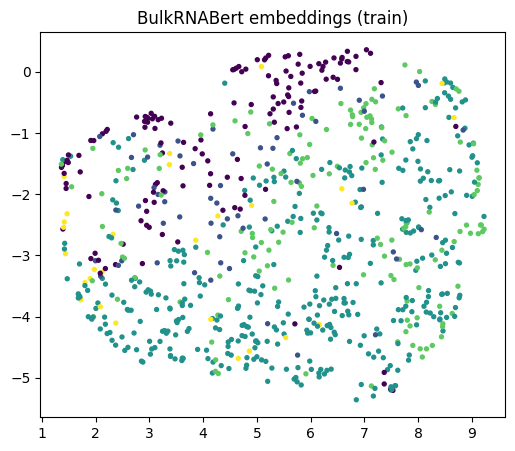

In [16]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(random_state=42)
Z = reducer.fit_transform(embds_train.numpy())

plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], c=y_train_enc, s=8)
plt.title("BulkRNABert embeddings (train)")
plt.show()
